# Feature importance and selection

In [1]:
from featimp import *

What is feature importance?

Feature importance is a technique used in machine learning to identify the most important features (i.e., variables) in a dataset for predicting a target variable. In essence, feature importance measures the contribution of each feature to the overall predictive power of a machine learning model.

To explore feature importance and selection, we will use a car dataset which includes the variables make, model, year, mileage, price, color, state, date, and price. Price will be our target variable (y).

#### Data cleaning and reshaping

In [2]:
X = df.drop(['price', 'date'], axis=1)
y = df['price']

In [3]:
X.head()

,make,model,year,mileage,color,state
0,Chevrolet,Cruze,2011,99157,white,TX
1,Toyota,Cruze,2017,19882,red,IL
2,Chevrolet,Altima,2011,77718,blue,CA
3,Nissan,Fusion,2012,83613,silver,TX
4,Ford,Cruze,2016,95349,red,NY


## Spearman's rank correlation coefficient

One straightforward approach for identifying significant regression features is ranking them by their Spearman's rank correlation coefficient. Spearman's rank coefficient measures the strength and direction of the relationship between two variables, similar to Pearson's correlation coefficient. However, unlike the Pearson correlation coefficient, which assumes a linear relationship between the variables and requires normally distributed data, Spearman's rank coefficient can handle non-linear relationships and non-normal data. 

The coefficient ranges from -1 to 1, where a value of 1 indicates a perfect positive relationship, 0 indicates no relationship, and -1 indicates a perfect negative relationship. It is important to keep in mind that while this method works well with independent features, it may not perform as well when dealing with codependent features.

Let's look at how each variable performs with respect to the target, y.

In [4]:
corrs = []
for col in X.columns:
    corr, _ = spearmanr(X[col], y)
    corrs.append(corr)
    print(f"column name: {col}, correlation: {corr}")

column name: make, correlation: 0.029341668753038994
column name: model, correlation: 0.030883199735239147
column name: year, correlation: -0.028275502656255173
column name: mileage, correlation: 0.03903017855235552
column name: color, correlation: 0.013177052062797293
column name: state, correlation: 0.05948980192580221


#### Visualizing importances (Spearman's correlation coefficient)

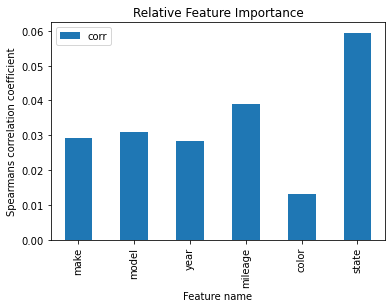

In [6]:
data1 = pd.DataFrame({'corr': corrs}, index = X.columns)
data1['corr'] = abs(data1['corr'])
data1.plot(kind='bar', stacked=True)
plt.xlabel('Feature name')
plt.ylabel('Spearmans correlation coefficient')
plt.title('Relative Feature Importance')
plt.show()

According to the plot, state and mileage are the most important features based on Spearman's rank correlation coefficient. Model, make, and year are the next most important, respectively.

## Model-based importance strategies

The importance of each feature is typically measured using a metric that reflects how much the feature contributes to the model's accuracy or predictive power. Some commonly used metrics for feature importance include gini importance, permutation importance, and drop importance. 

In the following section, we will explore permutation importance.

### Permutation importance

Permutation importance measures the decrease in a model's accuracy when the values of a particular feature are randomly shuffled.

Random forests are often used to calculate permutation importance because they are able to capture non-linear interactions between features, handle high-dimensional datasets, and provide robust predictions. In a random forest, each decision tree is trained on a random subset of the features and samples from the dataset, which helps to reduce overfitting and improve generalization.

Using a random forest to calculate permutation importance involves repeatedly permuting the values of a feature and evaluating the decrease in out-of-bag (OOB) accuracy or some other performance metric. This process can help identify which features are the most important for predicting the target variable, and can guide feature selection and engineering.

We will be using RandomForestRegressor, which requires categorical variables to be encoded. Then, we will fit a RandomForestRegressor on the data to find the most important features.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, ['make', 'model', 'year','color','state'])],
    remainder='passthrough')
X_encoded = preprocessor.fit_transform(X)
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X_encoded, y)
importances = model.feature_importances_
feature_names = X.columns
importance_arr = []
for name, importance in zip(feature_names, importances):
    importance_arr.append(importance)
    print(f"{name}: {importance}")

make: 0.021400630969319306
model: 0.022246651780801527
year: 0.02307620626949949
mileage: 0.02074299385982053
color: 0.02897094870932531
state: 0.021247897083305538


#### Visualizing importances (Permutation Importance)

Let's take a look at the importances of our features as determined by the RF model.

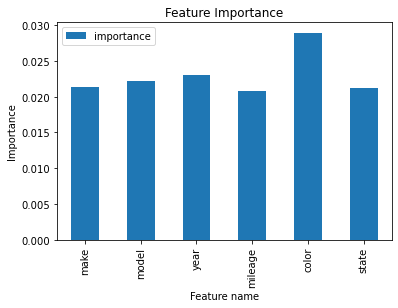

In [8]:
data2 = pd.DataFrame({'importance': importance_arr}, index = feature_names)
data2.plot(kind='bar', stacked=True)
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

According to the RandomForestRegressor, color and year are the most important features. 

We can see that this plot looks different from the Spearman's feature importance plot. This is because while random forest feature importance is based on the model's accuracy, Spearman's correlation is based on the relationship between the features and the target variable. Random forest feature importance is generally more useful for identifying the most important features for predicting the target variable, while Spearman's correlation can be useful for understanding the strength of the relationship between each feature and the target variable.

### Comparing strategies

We can use many different methods to find the top k features, such as Spearman's rank coefficient, PCA, linear regression (OLS), Random Forest, and XGBoost, to name a few. It's often the case that features determined for one model do not export well to other models.

In [9]:
rf_importances = importance_arr
spearman_importances = np.abs(data1['corr'])
feature_importances = pd.DataFrame({
    'Spearman': spearman_importances,
    'Random Forest': rf_importances
}, index=X.columns)
feature_importances

,Spearman,Random Forest
make,0.029342,0.021401
model,0.030883,0.022247
year,0.028276,0.023076
mileage,0.039030,0.020743
color,0.013177,0.028971
state,0.059490,0.021248


Let's take a look at the features side by side.

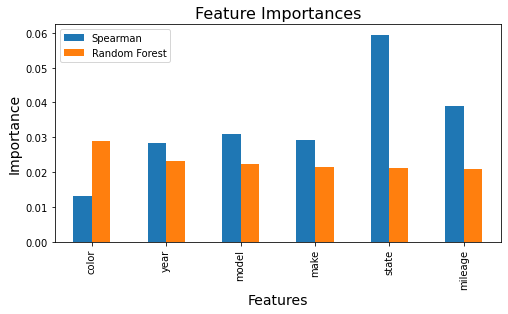

In [10]:
feature_importances = feature_importances.sort_values(by='Random Forest', ascending=False)
ax = feature_importances.plot(kind='bar', figsize=(8, 4), color=['tab:blue', 'tab:orange'])
ax.set_title('Feature Importances', fontsize=16)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
plt.show()

From this plot, we can see that Spearman and RF do not agree on which features are most important. 

One way to deal with this problem is by dropping one feature at a time, refitting the model, and looking at the validation metric to see if it has changed much. 

Since we only have 6 features in our original cars dataset, let's look at a dataset that needs more feature selection.

### Automatic feature selection algorithm

In [11]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
len(X.columns)

30

This breast cancer dataset has 30 features. 

To find the top k, the code loops over the features in descending order of importance and drops one feature at a time. Then, it retrains the model and computes the validation error. If the new error is better than the baseline error, the baseline error and feature importances are updated. If the new error is worse, the loop stops and the previous feature set is used.

In [12]:
k=3
baseline_error, final_error = automatic_feature_selection(X, y, k=k)

In [13]:
print(f"Validation error with all features: {baseline_error}")
print(f"Validation error with top {k} features: {final_error}")

Validation error with all features: 0.956140350877193
Validation error with top 3 features: 0.9473684210526315


We can see that the validation error differs very little when we use only 3 features as opposed to 30.

Using fewer features can make the model simpler and easier to understand and interpret, as well as reducing the computational cost and time required to train and apply the model, which is especially important when dealing with large datasets. This can also help avoid the curse of dimensionality, where high-dimensional data can become sparse and noisy, making it harder to find meaningful patterns and relationships. By reducing the number of features, the model can focus on the most relevant and informative aspects of the data, leading to better generalization and prediction performance.

In summary, using fewer features when modeling can lead to simpler, faster, more generalizable, and more reliable models.

### Variance and empirical p-values for feature importances

Having the variance or standard deviation of the feature importances is very useful because it can help us choose which features we want to include. Features with little to no variance are not able to tell us much about our data, as variation is information. To get the variation, which we will measure as standard deviation in the following example, we will bootstrap the data (randomly sample data with replacement to simulate multiple sub-samples) in order to estimate the variability of each feature's importance score. This approach can help provide a more accurate and robust estimate of a feature's importance, as it takes into account the potential variability in the data.

In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
n_samples = 1000
n_repeats = 10
importances = np.zeros((n_samples, X.shape[1]))

for i in range(n_repeats):
    X_boot, y_boot = resample(X, y, replace=True, random_state=i)
    rf.fit(X_boot, y_boot)
    importances[i*n_samples:(i+1)*n_samples] = rf.feature_importances_

In order to compare the variances, we will normalize our array (scale from 0 to 1).

In [15]:
std_dev = np.std(importances, axis=0)
norm = np.linalg.norm(std_dev)
normalized_sd = std_dev / norm

#### Visualizing variation in features

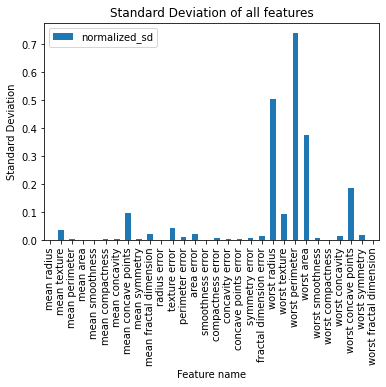

In [16]:
data2 = pd.DataFrame({'normalized_sd': normalized_sd}, index = X.columns)
data2.plot(kind='bar', stacked=True)
plt.xlabel('Feature name')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of all features')
plt.show()

When looking at standard deviation in feature selection, we want features with some variation. 

Features with low standard deviation tend to have little variation in their values, and as a result, may not provide much information to distinguish between different instances in the dataset. On the other hand, features with high standard deviation tend to have a wider range of values and may be more informative. Let's look at the features with the 6 highest standard deviations.

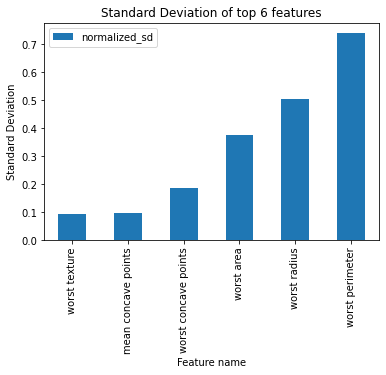

In [17]:
sorted_df = data2.sort_values(by='normalized_sd', ascending=True)
subset = sorted_df[-6:]
subset.plot(kind='bar', stacked=True)
plt.xlabel('Feature name')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of top 6 features')
plt.show()

From this plot, we can clearly see which features have the most variation. 

It is important to take standard deviation and variance into account when selecting features, as these metrics can provide useful information about the distribution and range of values for that feature.

Features with low variance and standard deviation may not be as important in predicting the target variable. Furthermore, if two or more features are highly correlated with each other, it may be redundant to include all of them in the model, as they may provide similar information. In such cases, selecting the feature with the highest variance or standard deviation can be a useful approach to feature selection.


### Summary 

Feature selection is the process of selecting a subset of relevant features from a larger set of features in a dataset. This is an important step in the modeling process, and is frequently used in the fields of bioinformatics, NLP, image processing, and more.

In summary, feature selection is an important technique in machine learning that can help improve model performance, reduce computation time, and increase interpretability.